<a href="https://colab.research.google.com/github/zxc-ghous/Anime-synopsis-and-genre-generator/blob/main/genre_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from keras.models import Sequential
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping
from keras import Input,Model
from tensorflow.keras import mixed_precision

In [ ]:
!pip install nltk

In [2]:
import nltk
from nltk.corpus import stopwords

In [31]:
#google colab gpu support 
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#google colab tpu support 
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [32]:
# On GPUs, use mixed_float16
# On TPUs, use 'mixed_bfloat16' instead
mixed_precision.set_global_policy('mixed_float16')

In [33]:
data=pd.read_csv('/content/drive/MyDrive/animes.csv')
data=data[['synopsis','genre']]
data=data.dropna()
data.reset_index(inplace=True,drop=True)
data.shape

(18336, 2)

In [34]:
# genre contains str, make it list[str, ...]
data['genre']=data['genre'].map(lambda x: re.split(r', ',re.sub(r"['\]\[]",'',x)))

In [35]:
index_without_genre=data[data['genre'].map(lambda x: np.nan if '' in x else x).isna()].index

In [36]:
data.drop(index=index_without_genre,inplace=True)

In [37]:
data.reset_index(inplace=True,drop=True)

In [38]:
mlb=MultiLabelBinarizer()

In [39]:
multi_labels=mlb.fit_transform(data['genre'])

In [40]:
genres_labels=pd.DataFrame(multi_labels,columns=mlb.classes_)

In [41]:
data=pd.concat([data,genres_labels],axis=1)

In [42]:
synopsis=data['synopsis']

In [43]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
def delete_bad_substrings(text: str) -> str:
  bad_substring=re.findall(r'source: \w+|written by mal rewrite',text)
  if bad_substring:
    text=re.sub(bad_substring[0],'',text)
  return text

In [45]:
def remove_stopwords(text: str) -> str:
   no_stopword_text = [w for w in text.split() if not w in stop_words]
   return ' '.join(no_stopword_text)

In [46]:
def make_clean_text(texts: 'pd.Series[str,]') -> 'pd.Series[str,]':
  texts=texts.str.lower()
  texts=texts.map(lambda x:delete_bad_substrings(x))
  texts=texts.map(lambda x:remove_stopwords(x))
  texts=texts.map(lambda x: re.sub(r'[\n\t\r]','',x))
  texts=texts.map(lambda x: re.sub(r'[\(\)\[\]]','',x))
  texts=texts.str.strip()
  return texts

In [47]:
synopsis=make_clean_text(synopsis)

In [48]:
input_dim=40000
input_length=200
output_dim=genres_labels.shape[1]

In [49]:
vectorize_layer = layers.TextVectorization(max_tokens=input_dim,
                                           output_sequence_length=input_length)
vectorize_layer.adapt(synopsis)

In [50]:
word_index=dict(zip(vectorize_layer.get_vocabulary(),range(vectorize_layer.vocabulary_size())))

In [51]:
tokenized_synopsis=vectorize_layer(synopsis).numpy()

In [52]:
X_train, X_test, y_train, y_test=train_test_split(tokenized_synopsis,genres_labels)

In [53]:
#glove embedding

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [29]:
path_to_glove_file=r'/content/glove.6B.200d.txt'

In [56]:
def create_glove_embeddings_index(path_to_glove_file):
  embeddings_index = {}
  with open(path_to_glove_file) as f:
      for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
  return embeddings_index

In [57]:
embeddings_index=create_glove_embeddings_index(path_to_glove_file)
print('len of embeddings_index %d' % len(embeddings_index))

len of embeddings_index 400000


In [58]:
#embedding matrix that we can use in a Keras Embedding layer. 
#It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our tokenizer vocabulary

def glove_embeddings_matrix(embeddings_index,word_index,pad_length=200):
  misses = 0
  embedding_matrix = np.zeros((len(word_index)+2, pad_length)) # Words not found in embedding index will be all-zeros.
  for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      misses +=1
  print('%d words not found in glove embeddings' % misses)
  return embedding_matrix

In [59]:
embedding_matrix = glove_embeddings_matrix(embeddings_index,word_index)

13159 words not found in glove embeddings


In [60]:
embedding_matrix.shape

(40002, 200)

In [61]:
embedding_layer=layers.Embedding(input_dim=embedding_matrix.shape[0],
                                 output_dim=embedding_matrix.shape[1],
                                 input_length=embedding_matrix.shape[1],
                                 weights=[embedding_matrix],
                                 trainable=False)

In [68]:
input=Input(shape=(200,))
x=embedding_layer(input)
x=layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x=layers.Bidirectional(layers.LSTM(128))(x)
x=layers.Dense(output_dim)(x)
outputs = layers.Activation('sigmoid', dtype='float32')(x)
glove_model=Model(input,outputs)
glove_model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=["categorical_accuracy"])
assert outputs.dtype.name=='float32', 'softmax and model output should be float32'
glove_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 200)          8000400   
                                                                 
 bidirectional_6 (Bidirectio  (None, 200, 256)         336896    
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 43)                11051     
                                                                 
 activation_2 (Activation)   (None, 43)                0   

In [69]:
callbacks=[
    EarlyStopping(patience=2,
                  monitor='val_loss',
                  restore_best_weights=True,
                  verbose=1)
]

In [ ]:
history=glove_model.fit(X_train,y_train,epochs=10,batch_size=128,validation_split=0.2,callbacks=callbacks)

In [ ]:
save_path=r'/content/drive/MyDrive/genre_predict_model'
glove_model.save(save_path)

In [84]:
glove_predictions=glove_model.predict(X_test)

In [85]:
glove_predictions=np.where(glove_predictions>0.2,1,0)

In [86]:
glove_f1_score_micro=f1_score(y_test,glove_predictions,average='micro')
glove_f1_score_macro=f1_score(y_test,glove_predictions,average='macro')
print('micro f1: ',glove_f1_score_micro)
print('macro f1: ',glove_f1_score_macro)

micro f1:  0.47971658390684435
macro f1:  0.324785153377765


In [87]:
glove_genres_f1_score=pd.Series(f1_score(y_test,glove_predictions,average=None),index=genres_labels.columns).sort_values(ascending=False)

Text(0.5, 1.0, 'f1 score of anime genres with glove embedding')

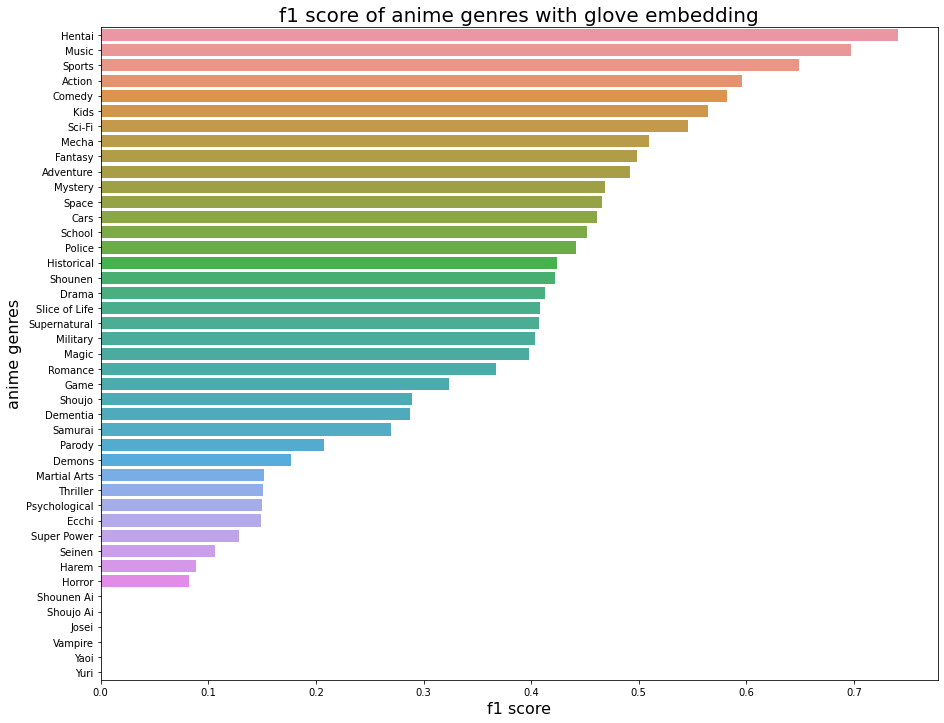

In [88]:
fig,ax=plt.subplots(figsize=(15,12))
bar_plot=sns.barplot(y=glove_genres_f1_score.index,x=glove_genres_f1_score)
plt.xlabel('f1 score', fontsize=16);
plt.ylabel('anime genres', fontsize=16,);
plt.title('f1 score of anime genres with glove embedding', fontsize=20)

In [89]:
fig=bar_plot.get_figure()
fig.savefig(r'/content/drive/MyDrive/anime_genres.png')

In [90]:
def text_to_genres_model(vectorize=vectorize_layer,trained_model=glove_model):
  string_input = Input(shape=(1,), dtype="string")
  x = vectorize(string_input)
  preds = trained_model(x)
  text_to_genres_model = Model(string_input, preds)
  return text_to_genres_model

In [91]:

def synopsis_to_predict(synopsis: pd.Series,vectorize=vectorize_layer,trained_model=glove_model,labels=genres_labels.columns):
  synopsis=make_clean_text(synopsis)
  model=text_to_genres_model(vectorize,trained_model)
  predictions=model.predict(synopsis)
  predictions=np.where(predictions>0.2,1,0)
  predicted_genres=[[genre for pred,genre in zip(prediction,labels) if pred==1] for prediction in predictions]
  return predicted_genres

In [92]:
forest_gump_text='''The film follows several decades in the life of a slow-witted and kindhearted Alabama man named Forrest Gump (Hanks) and his experiences in the 20th-century United States. The film differs substantially from the novel.'''
evangelion_text='''The Evangelion series revolves around the organization NERV, using large mechas called Evangelions to combat monstrous beings called Angels. They are piloted by several of the main characters, including Shinji Ikari, Asuka Sohryu, and Rei Ayanami. While the initial episodes focus largely on religious symbols and specific references to the Bible, the later episodes tend to go deeper into the psyches of the characters, where it is learned that many of them have deep-seated emotional and mental issues. '''

In [93]:
text=pd.Series([forest_gump_text,evangelion_text])
text

0    The film follows several decades in the life o...
1    The Evangelion series revolves around the orga...
dtype: object

In [ ]:
genres=synopsis_to_predict(text)
genres

[['Drama', 'Historical'], ['Action', 'Comedy', 'Mecha', 'Sci-Fi']]